In [1]:
#Initial imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, plot_roc_curve, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, StackingRegressor, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

# Set pandas to display all columns, since our data has many columns and we'd like to see them all
pd.set_option('display.max_columns', None)

In [1]:
def display_metrics(fit_model, Xtr, Xte, ytr, yte):
    '''
    This function takes in a fitted model, X train, X test, y train, and y test data.
    It uses the fitted model to get predicted values for the train and test data,
    and then uses sklearn's score functions to print out the accuracy, recall, precision,  f1, and roc-auc scores.
    It then plots a confusion matrix and roc-auc curve of the test data.
    '''
    
    train_preds = fit_model.predict(Xtr)
    test_preds = fit_model.predict(Xte)
    train_probs = fit_model.predict_proba(Xtr)[:,1]
    test_probs = fit_model.predict_proba(Xte)[:,1]

    train_accuracy = accuracy_score(ytr, train_preds)
    test_accuracy = accuracy_score(yte, test_preds)
    train_recall = recall_score(ytr, train_preds, zero_division=0)
    test_recall = recall_score(yte, test_preds, zero_division=0)
    train_precision = precision_score(ytr, train_preds, zero_division=0)
    test_precision = precision_score(yte, test_preds, zero_division=0)
    train_f1 = f1_score(ytr, train_preds, zero_division=0)
    test_f1 = f1_score(yte, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(ytr, train_probs)
    test_rocauc = roc_auc_score(yte, test_probs)

    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    
    plot_confusion_matrix(fit_model, Xte, yte)
    plot_roc_curve(fit_model, Xte, yte)

In [3]:
# Read in dataframe
df = pd.read_sas('../../data/nsch_2020_topical.sas7bdat')

# Map target column to boolean and rename to target
mask = {
    1.0: 1.0,
    2.0: 0.0
}
df['Target'] = df['K2Q35A'].map(mask)

# Drop rows where target is null
df.dropna(subset=['Target'], inplace=True)

In [4]:
# Define which columns to drop
drop_cols = [
    'A1_ACTIVE', 'A1_AGE', 'A1_BORN', 'A1_DEPLSTAT', 'A1_EMPLOYED', 'A1_GRADE', 'A1_LIVEUSA', 'A1_MARITAL',
    'A1_MENTHEALTH', 'A1_PHYSHEALTH', 'A1_RELATION', 'A1_SEX', 'A2_ACTIVE', 'A2_AGE', 'A2_BORN', 'A2_DEPLSTAT', 
    'A2_EMPLOYED', 'A2_GRADE', 'A2_LIVEUSA', 'A2_MARITAL', 'A2_MENTHEALTH', 'A2_PHYSHEALTH', 'A2_RELATION', 'A2_SEX', 
    'ALLERGIES_DESC', 'ARTHRITIS_DESC', 'ASKQUESTION', 'ASKQUESTION2', 'AUTISMMED', 'AUTISMTREAT', 'BESTFORCHILD', 
    'BLOOD_DESC', 'BMICLASS', 'BREASTFEDEND_DAY_S', 'BREASTFEDEND_MO_S', 'BREASTFEDEND_WK_S', 'CALMDOWN', 'CERPALS_DESC',
    'CLEAREXP', 'COLOR', 'CONFIDENT', 'COUNTTO', 'DIRECTIONS', 'DIRECTIONS2', 'DISCUSSOPT', 'DISTRACTED', 'DOCPRIVATE',
    'FAMCOUNT', 'FIPSST', 'FORMTYPE', 'FRSTFORMULA_DAY_S', 'FRSTFORMULA_MO_S','FRSTFORMULA_WK_S', 'FRSTSOLIDS_DAY_S', 
    'FRSTSOLIDS_MO_S', 'FRSTSOLIDS_WK_S', 'GENETIC_DESC', 'HCEXTENT', 'HEADACHE_DESC', 'HEART_DESC', 'HHCOUNT',
    'HHCOUNT_IF', 'HHID', 'HOURSLEEP', 'HOURSLEEP05', 'HURTSAD', 'K12Q01_A', 'K12Q01_B', 'K12Q01_C', 'K12Q01_D', 
    'K12Q01_E', 'K12Q01_F', 'K12Q01_G', 'K2Q30C', 'K2Q31C', 'K2Q32C', 'K2Q33C', 'K2Q34C', 'K2Q35A', 'K2Q35A_1_YEARS', 
    'K2Q35B', 'K2Q35C', 'K2Q35D', 'K2Q36C', 'K2Q37C', 'K2Q38C', 'K2Q40C', 'K2Q41C', 'K2Q42C', 'K2Q60C', 'K4Q26',
    'K4Q28X_EAR','K4Q37', 'K5Q11','K5Q21', 'K5Q22', 'K5Q32','K6Q08_R','K6Q10','K6Q12','K6Q13A','K6Q13B','K6Q14A','K6Q14B',
    'K6Q20','K6Q27', 'K6Q40', 'K6Q41R_STILL','K6Q42R_NEVER','K6Q43R_NEVER','K6Q60_R','K6Q61_R','K6Q70_R','K6Q72_R',
    'K6Q73_R','K9Q41', 'KEEPINSADULT','LIVEUSA_MO','LIVEUSA_YR','LIVEUSA_YR', 'K6Q42R_NEVER','MEDHISTORY','NEWACTIVITY',
    'ONEWORD','PLANNEEDS_R','PLAYWELL','POINT','RAISECONC','RECEIVECOPY','RECOGABC','RECOGBEGIN','RECSHAPES','RHYMEWORD',
    'SC_K2Q11','SC_K2Q12','SC_K2Q14','SC_K2Q15','SC_K2Q17','SC_K2Q18','SC_K2Q20','SC_K2Q21','SC_K2Q23','SC_RACEAIAN',
    'SC_RACEASIA','SESPLANMO','SESPLANYR','SIMPLEINST','SITSTILL','SLEEPPOS', 'SPCSERVMO','STARTSCHOOL','STRATUM',
    'TELLSTORY','TEMPER','THREEWORDS','TREATADULT', 'TREATNEED', 'TWOWORDS','UNDERSTAND', 'UNDERSTAND2', 'USEPENCIL', 
    'WORKTOFIN', 'WRITENAME', 'HEALTHKNOW', 'K8Q35', 'EMOSUPSPO', 'EMOSUPFAM', 'EMOSUPHCP', 'EMOSUPWOR', 'EMOSUPADV', 
    'EMOSUPPEER', 'EMOSUPMHP', 'EMOSUPOTH', 'K3Q20', 'K3Q22', 'K3Q21B', 'K7Q02R_R', 'DOCROOM', 'K4Q02_R', 'DENTISTVISIT', 
    'FWC', 'A1_GRADE_IF', 'FPL_IF', 'HIGRADE_TVIS', 'HIGRADE', 'INSTYPE', 'INSGAP', 'CURRINS', 'HOUSE_GEN', 'SC_SEX_IF', 
    'SC_HISPANIC_R_IF', 'SC_RACE_R_IF', 'TOTFEMALE', 'TOTMALE', 'AGEPOS4', 'SC_AGE_LT10', 'SC_AGE_LT9', 'SC_AGE_LT6', 
    'SC_AGE_LT4', 'TOTNONSHCN', 'TOTCSHCN', 'TOTAGE_12_17', 'TOTAGE_6_11', 'TOTAGE_0_5', 'MPC_YN', 'YEAR', 'K3Q04_R', 
    'TENURE'
]

# Define which cols to impute with no
no_cols = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3',
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04', 'K4Q28X05',
    'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 'CAVITIES',
    'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'ALLERGIES', 'ALLERGIES_CURR',
    'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART',
    'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B',
    'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN', 'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC',
    'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36A', 'K2Q36B', 'K2Q60A', 'K2Q60B', 'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B',
    'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01',
    'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27', 'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC',
    'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q36', 'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04',
    'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED', 'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3',
    'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12', 'ACE1', 'K7Q04R_R', 'WGTCONC', 'K4Q22_R', 'K4Q24_R',
    'K4Q04_R', 'K5Q31_R',  'BIRTHWT', 'BIRTHWT_L', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13',
    'SC_K2Q10', 'SC_CSHCN', 'K4Q30_R'
]

# Define which cols to impute with yes
yes_cols = [
    'S4Q01', 'CURRCOV', 'BORNUSA'
]

# Define which cols to impute with mode
mode_cols = [
    'HHLANGUAGE', 'K9Q40', 'K11Q60', 'K11Q61', 'K11Q62', 'S9Q34', 'K10Q11', 'K10Q12', 'K10Q13', 'K10Q14', 'K10Q20',
    'K10Q22', 'K10Q23', 'K9Q96', 'BULLIED_R', 'BULLY', 'TOTKIDS_R', 'SC_AGE_YEARS', 'BIRTH_MO', 'BIRTH_YR', 'SC_RACER', 
    'SC_RACE_R'
]

# Define which cols to impute with median
med_cols = [
    'MOMAGE', 'K11Q43R', 'K2Q01', 'K2Q01_D', 'K6Q71_R', 'TALKABOUT', 'WKTOSOLVE', 'STRENGTHS', 'HOPEFUL', 'K10Q30',
    'K10Q31', 'K10Q40_R', 'GOFORHELP', 'K10Q41_R', 'HOWMUCH', 'K8Q31', 'K8Q32', 'K8Q34', 'ATHOMEHC', 'ARRANGEHC',
    'SCREENTIME', 'K8Q11', 'HCABILITY', 'K8Q30', 'FAMILY_R', 'BIRTHWT_OZ_S', 'SC_ENGLISH', 'MAKEFRIEND',
    'BEDTIME', 'K7Q33'
]

# Define which cols to impute with median and add null flag
med_flag_cols = [
    'K5Q40', 'K5Q41', 'K5Q42', 'K5Q43', 'K5Q44', 'FOODSIT', 'MENBEVCOV'
]

# Define which cols to impute with constant 5
five_cols = [
    'K7Q84_R', 'K7Q85_R', 'K7Q82_R', 'K7Q83_R', 'K7Q70_R', 'K8Q21'
]

# Define lists to be used later

bool_two_no = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3', 
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04',
    'K4Q28X05', 'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 
    'CAVITIES', 'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'BLINDNESS', 'ALLERGIES', 
    'ALLERGIES_CURR', 'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q41A', 
    'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART', 'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 
    'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B', 'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN',
    'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC', 'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36A', 'K2Q36B', 'K2Q60A', 'K2Q60B',
    'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B', 'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 
    'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01', 'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27',
    'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC', 'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q36',
    'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04', 'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED',
    'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3', 'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12',
    'ACE1', 'K4Q22_R', 'K4Q24_R', 'K5Q31_R', 'BIRTHWT', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13', 
    'SC_K2Q10', 'SC_CSHCN', 'S4Q01', 'CURRCOV', 'BORNUSA'
]
bool_two_yes = ['K7Q04R_R', 'WGTCONC', 'K4Q04_R', 'BIRTHWT', 'K4Q30_R']

use_cols = [*no_cols, *yes_cols, *mode_cols, *med_cols, *med_flag_cols, *five_cols]

# Adds remaining columns with many nulls to drop cols
for col in df.columns:
    if col not in use_cols and col not in drop_cols:
        if (df[col].isna().sum() / len(df)) > .5:
            drop_cols.append(col)

In [5]:
# Map boolean columns to boolean
bool_mask_1 = {
    1: 1,
    2: 0,
    3: 0
}
bool_mask_2 = {
    1: 1,
    2: 1,
    3: 0
}
for col in bool_two_no:
    df[col] = df[col].map(bool_mask_1)
for col in bool_two_yes:
    df[col] = df[col].map(bool_mask_2)

# Define imputers to make up preprocessor
no_imp = Pipeline(steps=[
    ('no_imp', SimpleImputer(strategy='constant', fill_value=0))
])
yes_imp = Pipeline(steps=[
    ('yes_imp', SimpleImputer(strategy='constant', fill_value=1))
])
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent'))
])
med_imp = Pipeline(steps=[
    ('med_imp', SimpleImputer(strategy='median'))
])
med_flag_imp = Pipeline(steps=[
    ('med_flag_imp', SimpleImputer(strategy='median', add_indicator=True))
])
five_imp = Pipeline(steps=[
    ('five_imp', SimpleImputer(strategy='constant', fill_value=5))
])

In [6]:
# Create full preprocessor
full_preprocessor = ColumnTransformer(transformers=[
    ('no_pre', no_imp, no_cols),
    ('yes_pre', yes_imp, yes_cols),
    ('mode_pre', mode_imp, mode_cols),
    ('med_cols', med_imp, med_cols),
    ('med_flag_cols', med_flag_imp, med_flag_cols),
    ('five_cols', five_imp, five_cols)
])

In [7]:
# Drop the dropcols
df = df.drop(columns=[*drop_cols])

# Split to x and y
y = df['Target']
X = df.drop(columns=['Target'])

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [9]:
under_sampler = RandomUnderSampler(random_state=42, replacement=True)
X_train_u, y_train_u = under_sampler.fit_resample(X_train, y_train)

Running an untuned logistic regression, 


Train Accuracy:		0.7597266035751841
Test Accuracy:		0.9771895240777246

Train Recall:		0.526813880126183
Test Recall:		0.4479495268138801

Train Precision:	0.9862204724409449
Test Precision:		0.6761904761904762

Train f1:		0.6867717614804661
Test f1:		0.538899430740038

Train ROC-AUC:		0.9740900330716132
Test ROC-AUC:		0.9656302189645575


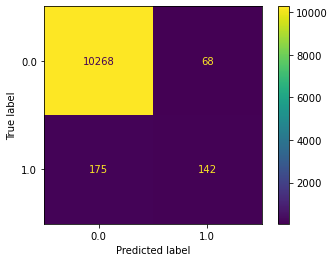

In [10]:
sink_logreg = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])
sink_logreg.fit(X_train, y_train)
display_metrics(sink_logreg, X_train_u, X_test, y_train_u, y_test)

Running an untuned decision tree


Train Accuracy:		1.0
Test Accuracy:		0.9633905941988172

Train Recall:		1.0
Test Recall:		0.3438485804416404

Train Precision:	1.0
Test Precision:		0.3745704467353952

Train f1:		1.0
Test f1:		0.35855263157894735

Train ROC-AUC:		1.0
Test ROC-AUC:		0.6631201106542568


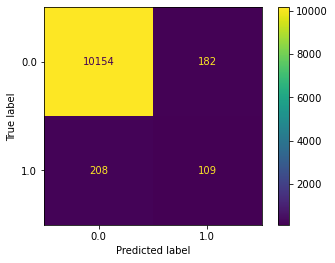

In [11]:
sink_tree = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('tree', DecisionTreeClassifier(
        class_weight='balanced'
    ))
])

sink_tree.fit(X_train, y_train)
display_metrics(sink_tree, X_train, X_test, y_train, y_test)

In [12]:
sink_tree.named_steps['tree'].tree_.max_depth

48

Tuning the tree

In [50]:
tuned_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

param_grid = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [None, 1, 5, 10, 25, 50],
    'tree__min_samples_leaf': [1, 2, 5, 10, 20],
    'tree__min_samples_split': [1, 2, 5, 10, 20]
}

grid_search = GridSearchCV(estimator=tuned_tree, param_grid=param_grid,
                           n_jobs=-1, 
                           verbose=2, 
                           return_train_score=True,
                           scoring='recall',
                           cv=StratifiedKFold(n_splits=5)
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 10.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('no_pre',
                                                                         Pipeline(steps=[('no_imp',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         ['SC_SEX',
                                                                          'K4Q32X01',
                                                                          'K4Q32X02',
                                                                          'K4Q32X03',
                                                                          'K4Q32X04',
            

In [51]:
new_tree = grid_search.best_estimator_
grid_search.best_params_

{'tree__criterion': 'entropy',
 'tree__max_depth': 5,
 'tree__min_samples_leaf': 20,
 'tree__min_samples_split': 2}


Train Accuracy:		0.8953626634958383
Test Accuracy:		0.8912982258518727

Train Recall:		0.9400630914826499
Test Recall:		0.8927444794952681

Train Precision:	0.21382444391293948
Test Precision:		0.20113717128642503

Train f1:		0.34840218238503506
Test f1:		0.3283062645011601

Train ROC-AUC:		0.9676350684627131
Test ROC-AUC:		0.9422832878377982


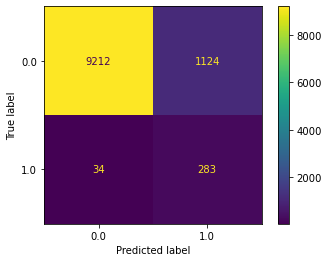

In [52]:
display_metrics(new_tree, X_train, X_test, y_train, y_test)

Gridsearch returned best metrics as default; tuning tree proving difficult, but can extract feature importance

In [16]:
feature_importance = dict(zip(use_cols, list(new_tree.named_steps['tree'].feature_importances_)))

In [17]:
feature_importance

{'SC_SEX': 0.007267292933884545,
 'K4Q32X01': 6.258213905746909e-05,
 'K4Q32X02': 0.0016563257418085754,
 'K4Q32X03': 6.159927326492427e-05,
 'K4Q32X04': 0.0004987024172289391,
 'K4Q32X05': 0.0004756816599852909,
 'DENTALSERV1': 6.237943168567754e-05,
 'DENTALSERV2': 7.017889922478559e-19,
 'DENTALSERV3': 1.0655734902702134e-17,
 'DENTALSERV4': 0.000521473123758979,
 'DENTALSERV5': 0.0005020221961877796,
 'DENTALSERV6': 0.0021139631776892842,
 'DENTALSERV7': 0.0,
 'K4Q28X01': 0.0,
 'K4Q28X02': 4.4398895427925574e-18,
 'K4Q28X03': 6.398413615484845e-05,
 'K4Q28X04': 0.0,
 'K4Q28X05': 0.0020456024598524887,
 'BREATHING': 0.00012224657294318281,
 'SWALLOWING': 0.00018008335657158497,
 'STOMACH': 0.00018941405892364493,
 'PHYSICALPAIN': 0.0001263407813161856,
 'HANDS': 0.00018612089446433527,
 'COORDINATION': 0.00018570470045012138,
 'TOOTHACHES': 0.0,
 'GUMBLEED': 6.31185882404946e-05,
 'CAVITIES': 1.6730826832403332e-06,
 'MEMORYCOND': 0.00012154729709184816,
 'WALKSTAIRS': 6.10600996596

In [18]:
new_cols = []
for key, value in feature_importance.items():
    if value > .005:
#         print(f'{key}, {value}')
        new_cols.append(key)

SC_SEX, 0.007267292933884545
K2Q36A, 0.020749103656962465
K2Q36B, 0.010267982809933929
K2Q30A, 0.0055509168653721025
K4Q36, 0.5328087589491206
SC_K2Q13, 0.02475995154373794
SC_CSHCN, 0.04949227529015936
BULLY, 0.005765033903527503
SC_AGE_YEARS, 0.01441780606788292
BIRTH_MO, 0.009442894588490864
MOMAGE, 0.013416843106179807
K11Q43R, 0.006856968229147242
SCREENTIME, 0.0050482098475123065
BIRTHWT_OZ_S, 0.010523198247382693
MAKEFRIEND, 0.07527830428221434
BEDTIME, 0.005121456005063243
K7Q33, 0.005841939164536272
MENBEVCOV, 0.005909559122212807


In [26]:
light_preproc = ColumnTransformer(transformers=[
    ('no_imp', no_imp, ['SC_SEX', 'K2Q36A', 'K2Q36B', 'K2Q30A', 'K4Q36', 'SC_K2Q13', 'SC_CSHCN']),
    ('mode_imp', mode_imp, ['SC_AGE_YEARS', 'BIRTH_MO']),
    ('med_imp', med_imp, ['MOMAGE', 'K11Q43R', 'SCREENTIME', 'BIRTHWT_OZ_S', 'MAKEFRIEND', 'BEDTIME', 'K7Q33']),
    ('med_flag_imp', med_flag_imp, ['MENBEVCOV'])
])

In [25]:
for col in new_cols:
    if col in no_cols:
        print(f'\n{col} no_cols')
    if col in yes_cols:
        print(f'\n{col} yes_cols')
    if col in mode_cols:
        print(f'\n{col} mode_cols')
    if col in med_cols:
        print(f'\n{col} med_cols')
    if col in med_flag_cols:
        print(f'\n{col} med_flag_cols')
    if col in five_cols:
        print(f'\n{col} five_cols')


SC_SEX no_cols

K2Q36A no_cols

K2Q36B no_cols

K2Q30A no_cols

K4Q36 no_cols

SC_K2Q13 no_cols

SC_CSHCN no_cols

BULLY mode_cols

SC_AGE_YEARS mode_cols

BIRTH_MO mode_cols

MOMAGE med_cols

K11Q43R med_cols

SCREENTIME med_cols

BIRTHWT_OZ_S med_cols

MAKEFRIEND med_cols

BEDTIME med_cols

K7Q33 med_cols

MENBEVCOV med_flag_cols


In [30]:
fewer_tree = Pipeline(steps=[
    ('preproc', light_preproc),
    ('tree', DecisionTreeClassifier(class_weight='balanced'))
])

param_grid = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [None, 1, 5, 10, 25, 50, 100],
    'tree__min_samples_leaf': [1, 2, 5, 10],
    'tree__min_samples_split': [1, 2, 5, 10]
}

grid_search = GridSearchCV(estimator=tuned_tree, param_grid=param_grid,
                           n_jobs=-1, 
                           verbose=2, 
                           return_train_score=True,
                           cv=StratifiedKFold(n_splits=5)
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  6.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('no_pre',
                                                                         Pipeline(steps=[('no_imp',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         ['SC_SEX',
                                                                          'K4Q32X01',
                                                                          'K4Q32X02',
                                                                          'K4Q32X03',
                                                                          'K4Q32X04',
            


Train Accuracy:		1.0
Test Accuracy:		0.9647047779968084

Train Recall:		1.0
Test Recall:		0.38485804416403785

Train Precision:	1.0
Test Precision:		0.40264026402640263

Train f1:		1.0
Test f1:		0.39354838709677414

Train ROC-AUC:		1.0
Test ROC-AUC:		0.6836732171284585


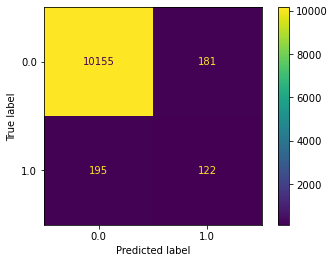

In [31]:
display_metrics(grid_search.best_estimator_, X_train, X_test, y_train, y_test)

In [32]:
grid_search.best_params_

{'tree__criterion': 'gini',
 'tree__max_depth': None,
 'tree__min_samples_leaf': 1,
 'tree__min_samples_split': 2}

In [44]:
nb = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('nb', MultinomialNB())
])

nb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('no_pre',
                                                  Pipeline(steps=[('no_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['SC_SEX', 'K4Q32X01',
                                                   'K4Q32X02', 'K4Q32X03',
                                                   'K4Q32X04', 'K4Q32X05',
                                                   'DENTALSERV1', 'DENTALSERV2',
                                                   'DENTALSERV3', 'DENTALSERV4',
                                                   'DENTALSERV5', 'DENTALSERV6',
                                                   'DENTALSERV7', 'K4Q28X01',
                                                   'K4Q28X02', 'K4Q28X03',
          


Train Accuracy:		0.9044996557982352
Test Accuracy:		0.9019055665070872

Train Recall:		0.8422712933753943
Test Recall:		0.8138801261829653

Train Precision:	0.21631109910883067
Test Precision:		0.20739549839228297

Train f1:		0.3442200257842715
Test f1:		0.33055733504164

Train ROC-AUC:		0.9472444860573358
Test ROC-AUC:		0.9412268290181754


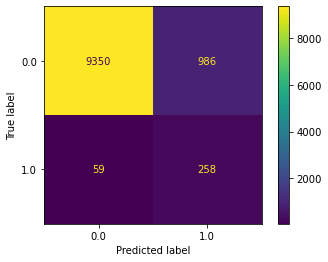

In [45]:
display_metrics(nb, X_train, X_test, y_train, y_test)

In [46]:
nb_coef = dict(zip(use_cols, list(nb.named_steps['nb'].coef_[0])))

In [ ]:
for key, val in nb_coef.items():
    if